# Исследование рынка общественного питания в Москве

**Цель проекта:** выбор подходящего формата и места для открытия заведения общественного питания в Москве.

**Задачи проекта:** исследовать рынок, найти интересные особенности и презентовать полученные результаты.

**Данные:** датасет с заведениями общественного питания Москвы, составленный летом 2022 года.

# Шаг 1. Загрузим данные и изучим общую информацию


In [121]:
#загрузим нужные библиотеки
import pandas as pd
import numpy as np
import datetime as dt
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(10,8)})
import math as mth
import warnings
warnings.filterwarnings('ignore')
from plotly import graph_objects as go

In [122]:
#загрузим данные в переменную 'data'
try:
   data = pd.read_csv('/datasets/moscow_places.csv', sep=',')
except:
   data = pd.read_csv('https://code.s3.yandex.net/datasets/moscow_places.csv', sep=',')
   
   data_copy = data.copy(deep=True)

In [123]:
#общая информация
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8406 entries, 0 to 8405
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               8406 non-null   object 
 1   category           8406 non-null   object 
 2   address            8406 non-null   object 
 3   district           8406 non-null   object 
 4   hours              7870 non-null   object 
 5   lat                8406 non-null   float64
 6   lng                8406 non-null   float64
 7   rating             8406 non-null   float64
 8   price              3315 non-null   object 
 9   avg_bill           3816 non-null   object 
 10  middle_avg_bill    3149 non-null   float64
 11  middle_coffee_cup  535 non-null    float64
 12  chain              8406 non-null   int64  
 13  seats              4795 non-null   float64
dtypes: float64(6), int64(1), object(7)
memory usage: 919.5+ KB


In [124]:
#первые строки
data.head()

,name,category,address,district,hours,lat,lng,rating,price,avg_bill,middle_avg_bill,middle_coffee_cup,chain,seats
0,WoWфли,кафе,"Москва, улица Дыбенко, 7/1",Северный административный округ,"ежедневно, 10:00–22:00",55.878494,37.478860,5.0,NaN,NaN,NaN,NaN,0,NaN
1,Четыре комнаты,ресторан,"Москва, улица Дыбенко, 36, корп. 1",Северный административный округ,"ежедневно, 10:00–22:00",55.875801,37.484479,4.5,выше среднего,Средний счёт:1500–1600 ₽,1550.0,NaN,0,4.0
2,Хазри,кафе,"Москва, Клязьминская улица, 15",Северный административный округ,"пн-чт 11:00–02:00; пт,сб 11:00–05:00; вс 11:00...",55.889146,37.525901,4.6,средние,Средний счёт:от 1000 ₽,1000.0,NaN,0,45.0
3,Dormouse Coffee Shop,кофейня,"Москва, улица Маршала Федоренко, 12",Северный административный округ,"ежедневно, 09:00–22:00",55.881608,37.488860,5.0,NaN,Цена чашки капучино:155–185 ₽,NaN,170.0,0,NaN
4,Иль Марко,пиццерия,"Москва, Правобережная улица, 1Б",Северный административный округ,"ежедневно, 10:00–22:00",55.881166,37.449357,5.0,средние,Средний счёт:400–600 ₽,500.0,NaN,1,148.0


### Описание данных

Данные о 8406 заведениях. Три типа данных: object, float64 и int. Есть пропущенные значения.

В таблице четырнадцать столбцов:

name — название заведения;\
address — адрес заведения;\
category — категория заведения, например «кафе», «пиццерия» или «кофейня»;\
hours — информация о днях и часах работы;\
lat — широта географической точки, в которой находится заведение;\
lng — долгота географической точки, в которой находится заведение;\
rating — рейтинг заведения по оценкам пользователей (высшая оценка — 5.0);\
price — категория цен в заведении: «средние», «ниже среднего», «выше среднего» и т.д;\
avg_bill — средняя стоимость заказа;\
middle_avg_bill — средний чек;\
middle_coffee_cup — цена одной чашки капучино;\
chain — показатель, является ли заведение сетевым ;\
district — административный район, в котором находится заведение;\
seats — количество посадочных мест.

# Шаг 2. Выполним предобработку данных

Пропусков в столбцах price, avg_bill, middle_avg_bill, middle_coffee_cup много, более 50% значений отсутствуют. В столбце seats, чуть меньше половины.\
Заполнение пропусков медианными значениями делать не будем, можем исказить общую картину.

In [125]:
#Проверим на явные дубликаты
data.duplicated().sum()

0

Создадим столбец street с названиями улиц из столбца с адресом:

In [126]:
#функцией split разобьем строки на подсроки по разделителю ','
data['street']=[x.split(',')[1] for x in data['address'].values]

Создадим столбец is_24/7 с обозначением, что заведение работает ежедневно и круглосуточно (24/7):\
логическое значение True — если заведение работает ежедневно и круглосуточно;\
логическое значение False — в противоположном случае

In [127]:
#contains() присвоит Ttue при наличии слов 'ежедневно, круглосуточно'
data['is_24_7'] = data['hours'].str.contains('ежедневно, круглосуточно')

In [128]:
#первые строки
data.head()

,name,category,address,district,hours,lat,lng,rating,price,avg_bill,middle_avg_bill,middle_coffee_cup,chain,seats,street,is_24_7
0,WoWфли,кафе,"Москва, улица Дыбенко, 7/1",Северный административный округ,"ежедневно, 10:00–22:00",55.878494,37.478860,5.0,NaN,NaN,NaN,NaN,0,NaN,улица Дыбенко,False
1,Четыре комнаты,ресторан,"Москва, улица Дыбенко, 36, корп. 1",Северный административный округ,"ежедневно, 10:00–22:00",55.875801,37.484479,4.5,выше среднего,Средний счёт:1500–1600 ₽,1550.0,NaN,0,4.0,улица Дыбенко,False
2,Хазри,кафе,"Москва, Клязьминская улица, 15",Северный административный округ,"пн-чт 11:00–02:00; пт,сб 11:00–05:00; вс 11:00...",55.889146,37.525901,4.6,средние,Средний счёт:от 1000 ₽,1000.0,NaN,0,45.0,Клязьминская улица,False
3,Dormouse Coffee Shop,кофейня,"Москва, улица Маршала Федоренко, 12",Северный административный округ,"ежедневно, 09:00–22:00",55.881608,37.488860,5.0,NaN,Цена чашки капучино:155–185 ₽,NaN,170.0,0,NaN,улица Маршала Федоренко,False
4,Иль Марко,пиццерия,"Москва, Правобережная улица, 1Б",Северный административный округ,"ежедневно, 10:00–22:00",55.881166,37.449357,5.0,средние,Средний счёт:400–600 ₽,500.0,NaN,1,148.0,Правобережная улица,False


Данные прошли предобработку и соответствуют необходимому уровню качества, для дальнейшего интеллектуального анализа и проверке гипотез.

# Шаг 3. Анализ данных

Количество объектов общественного питания по категориям:

In [129]:
data_ctg = data.groupby('category').agg({'name': 'count'}).sort_values(by='name', ascending=False).reset_index()
data_ctg.columns = ['category', 'count']
data_ctg

,category,count
0,кафе,2378
1,ресторан,2043
2,кофейня,1413
3,"бар,паб",765
4,пиццерия,633
5,быстрое питание,603
6,столовая,315
7,булочная,256


Построим столбчатую диаграмму для визуализации:

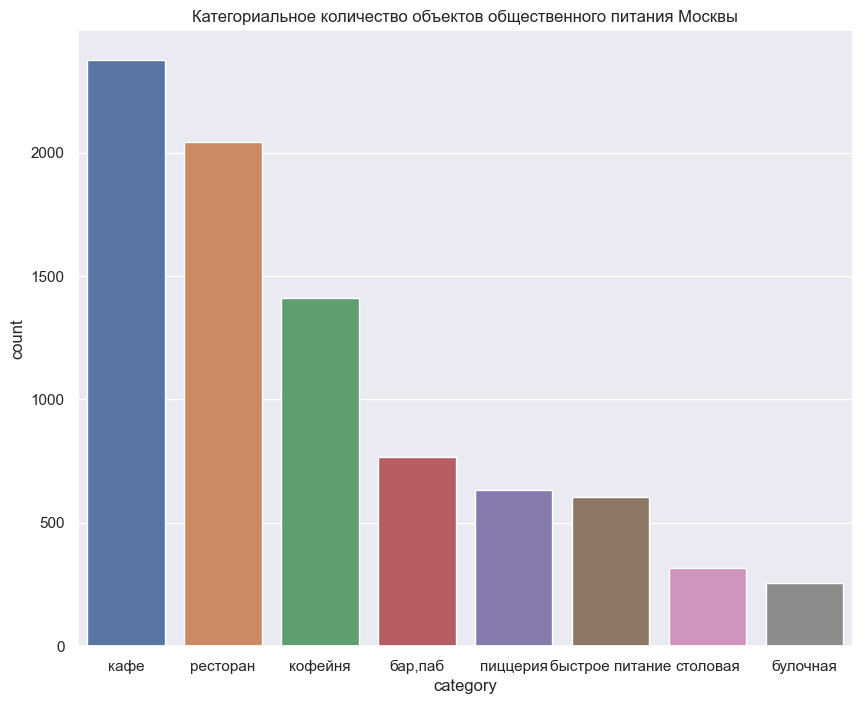

In [130]:
ax = sns.barplot(x='category', y='count', data=data_ctg).set(title='Категориальное количество объектов общественного питания Москвы')

Самая многочисленая категория - 2378  кафе, много ресторанов и кофеен - 2043 и 1413 соответственно.

Медианное количество посадочных мест по категориям:

In [137]:
data_seats = data.groupby('category').agg({'seats': 'median'}).sort_values(by='seats', ascending=False).reset_index().round()
data_seats

,category,seats
0,ресторан,86.0
1,"бар,паб",82.0
2,кофейня,80.0
3,столовая,76.0
4,быстрое питание,65.0
5,кафе,60.0
6,пиццерия,55.0
7,булочная,50.0


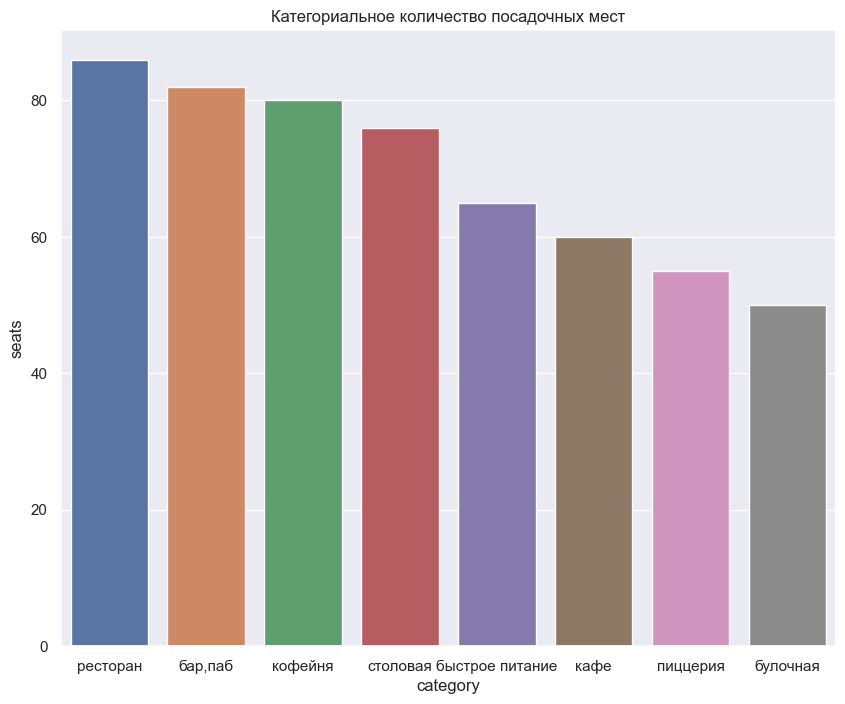

In [139]:
ax = sns.barplot(x='category', y='seats', data=data_seats).set(title='Категориальное количество посадочных мест')

Исследуйте количество посадочных мест в местах по категориям: рестораны, кофейни, пиццерии, бары и так далее. Постройте визуализации. Проанализируйте результаты и сделайте выводы

Рассмотрите и изобразите соотношение сетевых и несетевых заведений в датасете. Каких заведений больше?


Какие категории заведений чаще являются сетевыми? Исследуйте данные и ответьте на вопрос графиком.

Сгруппируйте данные по названиям заведений и найдите топ-15 популярных сетей в Москве. Под популярностью понимается количество заведений этой сети в регионе. Постройте подходящую для такой информации визуализацию. Знакомы ли вам эти сети? Есть ли какой-то признак, который их объединяет? К какой категории заведений они относятся?

In [ ]:
#уникальных названий
data['name'].nunique()

5614

Какие административные районы Москвы присутствуют в датасете? Отобразите общее количество заведений и количество заведений каждой категории по районам. Попробуйте проиллюстрировать эту информацию одним графиком.

Визуализируйте распределение средних рейтингов по категориям заведений. Сильно ли различаются усреднённые рейтинги в разных типах общепита?

Постройте фоновую картограмму (хороплет) со средним рейтингом заведений каждого района. Границы районов Москвы, которые встречаются в датасете, хранятся в файле admin_level_geomap.geojson (скачать файл для локальной работы)('https://code.s3.yandex.net/data-analyst/admin_level_geomap.geojson')

Отобразите все заведения датасета на карте с помощью кластеров средствами библиотеки folium.

Найдите топ-15 улиц по количеству заведений. Постройте график распределения количества заведений и их категорий по этим улицам. Попробуйте проиллюстрировать эту информацию одним графиком.

Найдите улицы, на которых находится только один объект общепита. Что можно сказать об этих заведениях?

Значения средних чеков заведений хранятся в столбце middle_avg_bill. Эти числа показывают примерную стоимость заказа в рублях, которая чаще всего выражена диапазоном. Посчитайте медиану этого столбца для каждого района. Используйте это значение в качестве ценового индикатора района. Постройте фоновую картограмму (хороплет) с полученными значениями для каждого района. Проанализируйте цены в центральном административном округе и других. Как удалённость от центра влияет на цены в заведениях?


Необязательное задание: проиллюстрируйте другие взаимосвязи, которые вы нашли в данных. Например, по желанию исследуйте часы работы заведений и их зависимость от расположения и категории заведения. Также можно исследовать особенности заведений с плохими рейтингами, средние чеки в таких местах и распределение по категориям заведений.

# Шаг 4. Детализируем исследование: открытие кофейни

Основателям фонда «Shut Up and Take My Money» не даёт покоя успех сериала «Друзья».\
Их мечта — открыть такую же крутую и доступную, как «Central Perk», кофейню в Москве.\
Будем считать, что заказчики не боятся конкуренции в этой сфере, ведь кофеен в больших городах уже достаточно.\
Попробуйте определить, осуществима ли мечта клиентов.\

Ответьте на следующие вопросы:\
Сколько всего кофеен в датасете? В каких районах их больше всего, каковы особенности их расположения?\
Есть ли круглосуточные кофейни?\
Какие у кофеен рейтинги? Как они распределяются по районам?\
На какую стоимость чашки капучино стоит ориентироваться при открытии и почему?\
По желанию вы можете расширить список вопросов для исследования, добавив собственные.\
Постройте визуализации. Попробуйте дать рекомендацию для открытия нового заведения.\
Это творческое задание: здесь нет правильного или неправильного ответа, но ваше решение должно быть чем-то обосновано.\
Объяснить свою рекомендацию можно текстом с описанием или маркерами на географической карте.


# Шаг 5. Подготовка презентации

Подготовьте презентацию исследования для инвесторов.\
Отвечая на вопросы о московском общепите, вы уже построили много диаграмм, и помещать каждую из них в презентацию не нужно.\ 
Выберите важные тезисы и наблюдения, которые могут заинтересовать заказчиков.\
Для создания презентации используйте любой удобный инструмент, но отправить презентацию нужно обязательно в формате PDF.\
Приложите ссылку на презентацию в markdown-ячейке в формате:\
Скопировать код\
Презентация: <ссылка на облачное хранилище с презентацией>\
Следуйте принципам оформления из темы «Подготовка презентации».

In [ ]:
print(plt.style.available) # вызовем разные наборы цветов 

['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


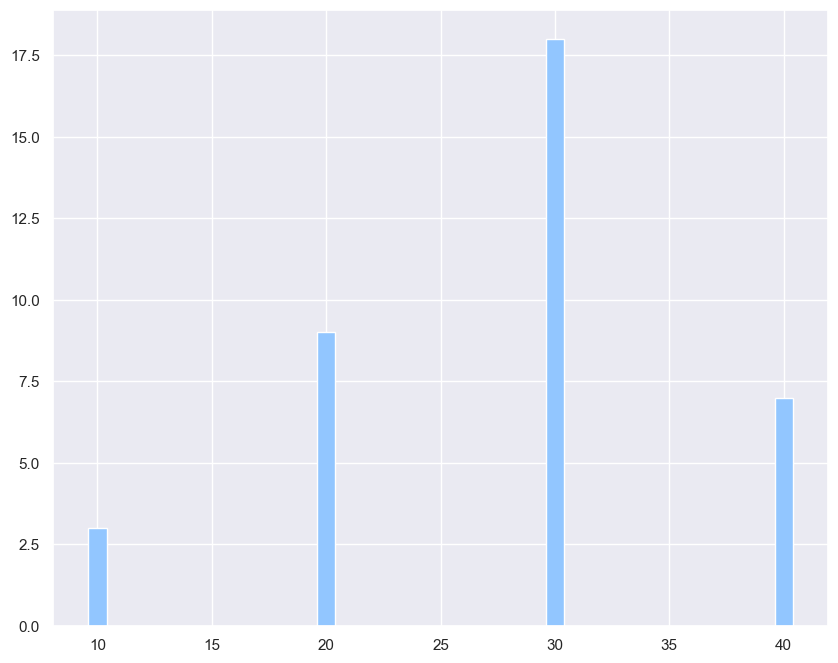

In [ ]:
with plt.style.context('seaborn-pastel'):
    plt.bar([10, 20, 30, 40],[3, 9, 18, 7]) 